# fish tracking

TOC:

0. imports
1. configuration
2. paths (input data, outroot)
3. cluster config
4. open tag log and reference model
    1. read tag data and clean
    2. read reference model, clean and subset
6. compute differences
    1. align time
    2. convert model depth to appropriate units (sigma → depth (→ pressure))
    3. subtract tags from aligned model
    4. save
7. regrid to healpix
    1. define healpix grid
    2. create target grid
    3. compute weights
    4. regrid
    5. save
8. construct emission matrix
    1. compute ocean mask
    2. compute normal probability density function from differences and the configured parameters
    3. compute maximum expected model parameter
    4. save
9. additional emission matrices: acoustic ranges
    1. open and read acoustic detections for the selected tag
    2. convert times to UTC
    3. aggregate detections and compute weights
    4. construct detection maps
    5. weighted sum of the detection maps
    6. save
10. estimate the model parameter
    1. select and create estimator instance
    2. create an optimizer using the estimator and the expected parameter range
    3. fit the model to the data to get the model parameter
    4. save
11. compute the state probabilities
    1. use the configured estimator to predict the state probabilities
    2. save
12. compute the tracks
    1. compute mean and mode from the precomputed state probabilities and apply the viterbi algorithm to the emission matrix to get the most probable track
    2. save
13. visualization
    1. plot the emission matrix
    2. plot the state probabilities
    3. plot each of the tracks

!pip install git+https://github.com/iaocea/xarray-healpy
!pip install rich dask_image zstandard xmovie
!pip install -e ../.

In [1]:
import json

import cf_xarray
import dask
import fsspec
import intake
import numba
import numpy as np
import pandas as pd
import pint_xarray
import xarray as xr
from pint_xarray import unit_registry as ureg

In [2]:
from pangeo_fish.hmm.estimator import EagerScoreEstimator
from pangeo_fish.io import open_tag
from pangeo_fish.pdf import combine_emission_pdf

configuration

<div class="alert alert-info">

**Note**: This contains model parameters only
    
</div>

In [4]:
tag_name = "A19124"
bbox = {"lat": [47, 51], "lon": [-8, -2]}

relative_depth_threshold = 0.6

nside = 4096
rot = {"lat": 0, "lon": 0}
min_vertices = 1

differences_std = 0.75
recapture_std = 1e-2

earth_radius = ureg.Quantity(6371, "km")
adjustment_factor = 5  # for a more fuzzy search
maximum_speed = ureg.Quantity(60, "km / day")
truncate = 4

receiver_buffer = ureg.Quantity(1000, "m")

tolerance = 1e-2

track_modes = ["mean", "mode"]# , "viterbi", "viterbi2"]
additional_track_quantities = ["speed", "distance"]

tag_root = "https://data-taos.ifremer.fr/data_tmp/cleaned/tag/"
catalog_url = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"


storage_options = {
    'anon': False, 
    'profile' : "gfts",
    'client_kwargs': {
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    }}

scratch_root="s3://destine-gfts-data-lake/tinatest3"

#scratch_root = "."
#storage_options = None


paths

In [5]:
target_root = f"{scratch_root}/{tag_name}"
tracks_root = f"{target_root}/tracks"

cluster config

In [6]:
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41153,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:39043,Total threads: 2
Dashboard: http://127.0.0.1:45571/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:44543,


open tag data

In [7]:
tag = open_tag(tag_root, tag_name)
tag

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       pit_tag_id:       A19124
│       acoustic_tag_id:  OPI-372
│       scientific_name:  Pollachius pollachius
│       common_name:      Pollock
│       project:          FISHINTEL
├── DataTree('dst')
│       Dimensions:      (time: 20680)
│       Coordinates:
│         * time         (time) datetime64[ns] 2022-06-12T22:00:00 ... 2022-07-04T10:...
│       Data variables:
│           temperature  (time) float64 17.58 17.53 17.5 17.44 ... 20.53 20.55 20.66
│           pressure     (time) float64 1.43 1.43 1.43 1.5 1.5 ... 1.81 1.81 1.81 1.81
├── DataTree('tagging_events')
│       Dimensions:     (event_name: 2)
│       Coordinates:
│         * event_name  (event_name) object 'release' 'fish_death'
│       Data variables:
│           time        (event_name) datetime64[ns] 2022-06-13T11:40:00 2022-06-24T07...
│           longitude   (event_name) float64 -5.098 -5.136
│           latitude    (event_name) float64 48.45 48.43
└── DataTree('acoustic')
        Dimensions:        (time: 48)
        Coordinates:
          * time           (time) datetime64[ns] 2022-06-13T13:41:49 ... 2022-06-13T1...
        Data variables:
            deployment_id  (time) int64 28689 28689 28690 28690 ... 28690 28690 28690
            longitude      (time) float64 -5.103 -5.103 -5.112 ... -5.112 -5.112 -5.112
            latitude       (time) float64 48.45 48.45 48.45 48.45 ... 48.45 48.45 48.45

## compare reference model with tag log

In [8]:
from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.diff import diff_z
from pangeo_fish.io import open_copernicus_catalog
from pangeo_fish.tags import adapt_model_time, reshape_by_bins, to_time_slice

drop data outside the reference interval

In [9]:
time_slice = to_time_slice(tag["tagging_events/time"])
tag_log = tag["dst"].ds.sel(time=time_slice)
tag_log

<xarray.Dataset>
Dimensions:      (time: 10384)
Coordinates:
  * time         (time) datetime64[ns] 2022-06-13T11:40:30 ... 2022-06-24T07:...
Data variables:
    temperature  (time) float64 14.66 14.66 14.66 14.59 ... 14.34 14.34 14.36
    pressure     (time) float64 2.31 4.0 11.87 11.68 13.5 ... 2.0 1.93 2.0 2.0

open and clean reference model

In [10]:
cat = intake.open_catalog(catalog_url)
model = open_copernicus_catalog(cat)
model

/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "depth" starting at index 11. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset>
Dimensions:             (time: 41952, depth: 33, lat: 1240, lon: 958)
Coordinates:
  * depth               (depth) float32 0.0 3.0 5.0 10.0 ... 3e+03 4e+03 5e+03
  * lat                 (lat) float32 46.0 46.01 46.03 ... 62.72 62.73 62.74
  * lon                 (lon) float32 -16.0 -15.97 -15.94 ... 12.94 12.97 13.0
  * time                (time) datetime64[ns] 2019-01-01T01:00:00 ... 2023-10-15
    latitude            (lat, lon) float32 46.0 46.0 46.0 ... 62.74 62.74 62.74
    longitude           (lat, lon) float32 -16.0 -15.97 -15.94 ... 12.97 13.0
Data variables:
    TEMP                (time, depth, lat, lon) float32 dask.array<chunksize=(8, 11, 1240, 958), meta=np.ndarray>
    XE                  (time, lat, lon) float32 dask.array<chunksize=(8, 1240, 958), meta=np.ndarray>
    H0                  (lat, lon) float32 dask.array<chunksize=(620, 479), meta=np.ndarray>
    mask                (depth, lat, lon) float32 dask.array<chunksize=(11, 1240, 958), meta=np.ndarray>
    dynamic_depth       (depth, time, lat, lon) float32 dask.array<chunksize=(33, 8, 1240, 958), meta=np.ndarray>
    dynamic_bathymetry  (lat, lon, time) float32 dask.array<chunksize=(620, 479, 8), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2020-09-30T00:08:59Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

subset the model

In [11]:
reference_model = (
    # align model time with tag log
    model.sel(time=adapt_model_time(time_slice))
    # subset the data to the region of interest using a bbox
    .sel(lat=slice(*bbox["lat"]), lon=slice(*bbox["lon"]))
    # drop data for depth layers that are too unlikely
    .pipe(
        lambda ds: ds.sel(
            depth=slice(None, (tag_log["pressure"].max() - ds["XE"].min()).compute())
        )
    )
)
reference_model

<xarray.Dataset>
Dimensions:             (time: 260, depth: 9, lat: 297, lon: 199)
Coordinates:
  * depth               (depth) float32 0.0 3.0 5.0 10.0 ... 20.0 25.0 30.0 40.0
  * lat                 (lat) float32 47.0 47.01 47.03 ... 50.97 50.99 51.0
  * lon                 (lon) float32 -8.0 -7.97 -7.939 ... -2.061 -2.03 -2.0
  * time                (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06...
    latitude            (lat, lon) float32 47.0 47.0 47.0 ... 51.0 51.0 51.0
    longitude           (lat, lon) float32 -8.0 -7.97 -7.939 ... -2.03 -2.0
Data variables:
    TEMP                (time, depth, lat, lon) float32 dask.array<chunksize=(5, 9, 297, 199), meta=np.ndarray>
    XE                  (time, lat, lon) float32 dask.array<chunksize=(5, 297, 199), meta=np.ndarray>
    H0                  (lat, lon) float32 dask.array<chunksize=(297, 199), meta=np.ndarray>
    mask                (depth, lat, lon) float32 dask.array<chunksize=(9, 297, 199), meta=np.ndarray>
    dynamic_depth       (depth, time, lat, lon) float32 dask.array<chunksize=(9, 5, 297, 199), meta=np.ndarray>
    dynamic_bathymetry  (lat, lon, time) float32 dask.array<chunksize=(297, 199, 5), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2020-09-30T00:08:59Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

reshape the tag log

In [12]:
%%time
reshaped_tag = reshape_by_bins(
    tag_log,
    dim="time",
    bins=(
        reference_model.cf.add_bounds(["time"], output_dim="bounds")
        .pipe(bounds_to_bins, bounds_dim="bounds")
        .get("time_bins")
    ),
    bin_dim="bincount",
    other_dim="obs",
).chunk({"time": 1})
reshaped_tag

CPU times: user 543 ms, sys: 18.5 ms, total: 561 ms
Wall time: 550 ms


<xarray.Dataset>
Dimensions:      (obs: 40, time: 260)
Coordinates:
  * obs          (obs) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * time         (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:...
Data variables:
    temperature  (time, obs) float64 dask.array<chunksize=(1, 40), meta=np.ndarray>
    pressure     (time, obs) float64 dask.array<chunksize=(1, 40), meta=np.ndarray>

subtract the tag data from the model

In [14]:
%%time
diff = (
    diff_z(reference_model, reshaped_tag, depth_threshold=relative_depth_threshold)
    .assign_attrs({"tag_id": tag_name})
    .assign(
        {
            "H0": reference_model["H0"],
            "ocean_mask": reference_model["H0"].notnull(),
        }
    )
)
diff

CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 19.2 ms


<xarray.Dataset>
Dimensions:     (lat: 297, lon: 199, time: 260)
Coordinates:
  * lat         (lat) float32 47.0 47.01 47.03 47.04 ... 50.96 50.97 50.99 51.0
  * lon         (lon) float32 -8.0 -7.97 -7.939 -7.909 ... -2.061 -2.03 -2.0
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
    latitude    (lat, lon) float32 47.0 47.0 47.0 47.0 ... 51.0 51.0 51.0 51.0
    longitude   (lat, lon) float32 -8.0 -7.97 -7.939 ... -2.061 -2.03 -2.0
Data variables:
    diff        (time, lat, lon) float32 dask.array<chunksize=(1, 297, 199), meta=np.ndarray>
    H0          (lat, lon) float32 dask.array<chunksize=(297, 199), meta=np.ndarray>
    ocean_mask  (lat, lon) bool dask.array<chunksize=(297, 199), meta=np.ndarray>
Attributes:
    tag_id:   A19124

Verify the data

In [20]:
diff=diff.persist()

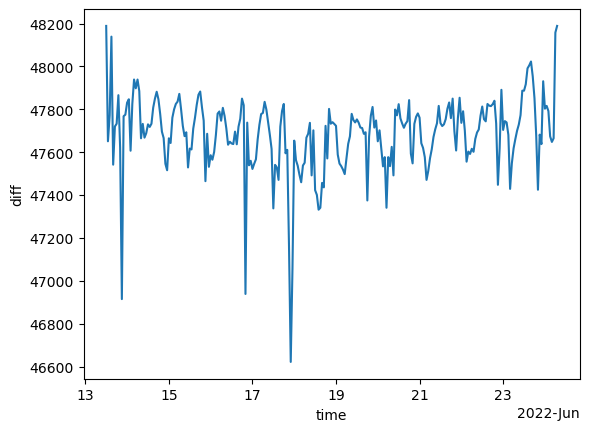

In [21]:
diff["diff"].count(["lat", "lon"]).plot()

save snapshot to disk

In [22]:
%%time
diff.chunk({"time": 1, "lat": -1, "lon": -1}).to_zarr(
    f"{target_root}/diff.zarr", mode="w"#, consolidated=True
    ,storage_options=storage_options
)

CPU times: user 1.75 s, sys: 127 ms, total: 1.87 s
Wall time: 10.7 s


cleanup

In [23]:
del tag_log, cat, model, reference_model, reshaped_tag, diff

## regrid to healpix

In [24]:
from xarray_healpy import HealpyGridInfo, HealpyRegridder

from pangeo_fish.grid import center_longitude

open the diff and clean

In [25]:
%%time
ds = (
    xr.open_dataset(f"{target_root}/diff.zarr", engine="zarr", chunks={}
                       ,storage_options=storage_options
)
    .pipe(lambda ds: ds.merge(ds[["latitude", "longitude"]].compute()))
    .swap_dims({"lat": "yi", "lon": "xi"})
    .drop_vars(["lat", "lon"])
)
ds

CPU times: user 53.4 ms, sys: 17.8 ms, total: 71.3 ms
Wall time: 282 ms


<xarray.Dataset>
Dimensions:     (yi: 297, xi: 199, time: 260)
Coordinates:
    latitude    (yi, xi) float32 47.0 47.0 47.0 47.0 ... 51.0 51.0 51.0 51.0
    longitude   (yi, xi) float32 -8.0 -7.97 -7.939 -7.909 ... -2.061 -2.03 -2.0
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
Dimensions without coordinates: yi, xi
Data variables:
    H0          (yi, xi) float32 dask.array<chunksize=(297, 199), meta=np.ndarray>
    diff        (time, yi, xi) float32 dask.array<chunksize=(1, 297, 199), meta=np.ndarray>
    ocean_mask  (yi, xi) bool dask.array<chunksize=(297, 199), meta=np.ndarray>
Attributes:
    tag_id:   A19124

define the target grid

In [26]:
grid = HealpyGridInfo(level=int(np.log2(nside)), rot=rot)
grid

HealpyGridInfo(level=12, rot={'lat': 0, 'lon': 0})

In [27]:
target_grid = grid.target_grid(ds).pipe(center_longitude, 0)
target_grid

<xarray.Dataset>
Dimensions:     (cells: 76030)
Coordinates:
    cell_ids    (cells) uint64 56094329 56094330 56094331 ... 57955392 57955456
    latitude    (cells) float64 47.01 47.01 47.03 47.01 ... 50.98 50.98 50.98
    longitude   (cells) float64 -2.02 -2.044 -2.02 ... -7.614 -7.507 -7.722
    resolution  float64 0.0002498
Dimensions without coordinates: cells
Data variables:
    *empty*
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

compute the interpolation weights

In [28]:
%%time
regridder = HealpyRegridder(
    ds[["longitude", "latitude", "ocean_mask"]],
    target_grid,
    method="bilinear",
    interpolation_kwargs={"mask": "ocean_mask", "min_vertices": min_vertices},
)
regridder

CPU times: user 5.11 s, sys: 67 ms, total: 5.17 s
Wall time: 5.12 s


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray_healpy/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


HealpyRegridder(method='bilinear', interpolation_kwargs={'mask': 'ocean_mask', 'min_vertices': 1})

regrid

In [29]:
%%time
regridded = regridder.regrid_ds(ds)
regridded

CPU times: user 1.52 s, sys: 158 ms, total: 1.67 s
Wall time: 1.64 s


<xarray.Dataset>
Dimensions:     (cells: 76030, time: 260)
Coordinates:
    cell_ids    (cells) uint64 56094329 56094330 56094331 ... 57955392 57955456
    latitude    (cells) float64 47.01 47.01 47.03 47.01 ... 50.98 50.98 50.98
    longitude   (cells) float64 -2.02 -2.044 -2.02 ... -7.614 -7.507 -7.722
    resolution  float64 0.0002498
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
Dimensions without coordinates: cells
Data variables:
    H0          (cells) float64 dask.array<chunksize=(76030,), meta=np.ndarray>
    diff        (time, cells) float64 dask.array<chunksize=(1, 76030), meta=np.ndarray>
    ocean_mask  (cells) float64 dask.array<chunksize=(76030,), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

reshape to 2D

In [30]:
%%time
reshaped = grid.to_2d(regridded).pipe(center_longitude, 0)
reshaped

CPU times: user 2.69 s, sys: 1.7 s, total: 4.39 s
Wall time: 2.17 s


<xarray.Dataset>
Dimensions:     (y: 251, x: 540, time: 260)
Coordinates:
    resolution  float64 0.0002498
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
    cell_ids    (y, x) int64 56029036 56029038 56029124 ... 58017552 58017554
    latitude    (y, x) float64 44.02 44.03 44.04 44.05 ... 53.62 53.63 53.64
    longitude   (y, x) float64 -7.475 -7.477 -7.479 ... -2.17 -2.17 -2.171
Dimensions without coordinates: y, x
Data variables:
    H0          (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    diff        (time, y, x) float64 dask.array<chunksize=(1, 251, 540), meta=np.ndarray>
    ocean_mask  (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    level:      12
    nside:      4096
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

Verify the data

In [31]:
reshaped=reshaped.persist()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 10.45 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


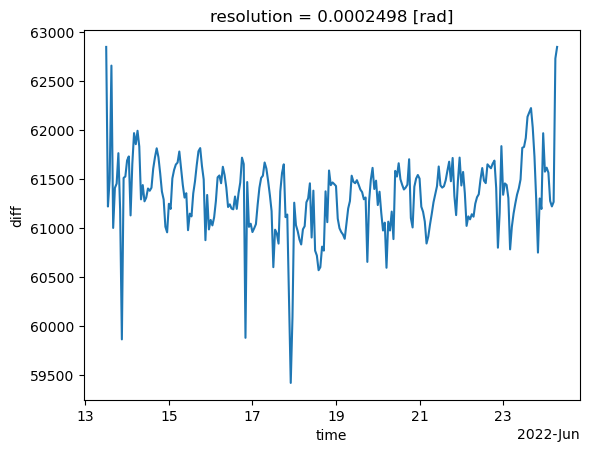

In [32]:
reshaped["diff"].count(["x", "y"]).plot()

save

In [33]:
%%time
reshaped.chunk({"x": -1, "y": -1, "time": 1}).to_zarr(
    f"{target_root}/diff-regridded.zarr",
    mode="w",
    consolidated=True,
    compute=True,
    storage_options=storage_options,
)

CPU times: user 1.52 s, sys: 118 ms, total: 1.64 s
Wall time: 8.55 s


cleanup

In [34]:
del ds, grid, target_grid, regridder, regridded, reshaped

## construct emission matrix

In [35]:
from toolz.dicttoolz import valfilter
from pangeo_fish.distributions import create_covariances, normal_at
from pangeo_fish.pdf import normal
from pangeo_fish.utils import temporal_resolution

open data

In [36]:
differences = xr.open_dataset(
    f"{target_root}/diff-regridded.zarr",
    engine="zarr",
    chunks={},
    storage_options=storage_options,
)
differences

<xarray.Dataset>
Dimensions:     (y: 251, x: 540, time: 260)
Coordinates:
    cell_ids    (y, x) int64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
Dimensions without coordinates: y, x
Data variables:
    H0          (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    diff        (time, y, x) float64 dask.array<chunksize=(1, 251, 540), meta=np.ndarray>
    ocean_mask  (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

initial and final position

In [38]:
grid = differences[["latitude", "longitude"]].compute()

initial_position = tag["tagging_events"].ds.sel(event_name="release")
cov = create_covariances(1e-6, coord_names=["latitude", "longitude"])
initial_probability = normal_at(
    grid, pos=initial_position, cov=cov, normalize=True, axes=["latitude", "longitude"]
)

final_position = tag["tagging_events"].ds.sel(event_name="fish_death")
if final_position[["longitude", "latitude"]].to_dataarray().isnull().all():
    final_probability = None
else:
    cov = create_covariances(recapture_std**2, coord_names=["latitude", "longitude"])
    final_probability = normal_at(
        grid,
        pos=final_position,
        cov=cov,
        normalize=True,
        axes=["latitude", "longitude"],
    )

maximum displacement

In [39]:
earth_radius_ = xr.DataArray(earth_radius, dims=None)

timedelta = temporal_resolution(differences["time"]).pint.quantify().pint.to("h")
grid_resolution = earth_radius_ * differences["resolution"].pint.quantify()

maximum_speed_ = xr.DataArray(maximum_speed, dims=None).pint.to("km / h")
max_grid_displacement = maximum_speed_ * timedelta * adjustment_factor / grid_resolution

max_sigma = max_grid_displacement.pint.to("dimensionless").pint.magnitude / truncate
max_sigma

/home/jovyan/pangeo-fish/pangeo_fish/utils.py:122: FutureWarning: Hour.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  timedelta = to_offset(freq).delta.to_numpy()


1.963306279189256

emission probability matrix

In [40]:
%%time
emission_pdf = (
    normal(differences["diff"], mean=0, std=differences_std, dims=["y", "x"])
    .to_dataset(name="pdf")
    .assign(
        valfilter(
            lambda x: x is not None,
            {
                "initial": initial_probability,
                "final": final_probability,
                "mask": differences["ocean_mask"],
            },
        )
    )
    .assign_attrs(differences.attrs | {"max_sigma": max_sigma})
    .chunk()
)
emission_pdf

CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 16.7 ms


<xarray.Dataset>
Dimensions:     (y: 251, x: 540, time: 260)
Coordinates:
    cell_ids    (y, x) int64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
Dimensions without coordinates: y, x
Data variables:
    pdf         (time, y, x) float64 dask.array<chunksize=(1, 251, 540), meta=np.ndarray>
    initial     (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    final       (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    mask        (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  1.963306279189256

Verify the data

In [41]:
emission_pdf=emission_pdf.persist()

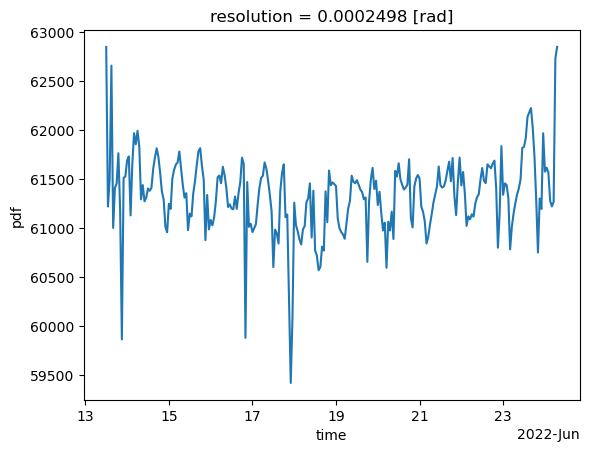

In [42]:
emission_pdf["pdf"].count(["x", "y"]).plot()

save

In [43]:
emission_pdf.chunk({"time": 1, "y": -1, "x": -1}).to_zarr(
    f"{target_root}/emission.zarr", mode="w", consolidated=True,
    storage_options=storage_options,
)

cleanup

In [44]:
del differences, grid, initial_probability, final_probability, emission_pdf

## additional emission probability matrix from acoustic ranges

In [58]:
from pangeo_fish import acoustic, utils

open data and clean

In [59]:
emission = xr.open_dataset(
    f"{target_root}/emission.zarr", engine="zarr", chunks={"x": -1, "y": -1},
    storage_options=storage_options,

)

construct the emission probabilities

In [60]:
acoustic_pdf = acoustic.emission_probability(
    tag, emission[["time", "cell_ids", "mask"]].compute(), receiver_buffer
)
combined = emission.merge(acoustic_pdf)
combined

<xarray.Dataset>
Dimensions:     (y: 251, x: 540, time: 260)
Coordinates:
    cell_ids    (y, x) int64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-13T12:00:00 ... 2022-06-24T07:0...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    initial     (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    mask        (y, x) float64 dask.array<chunksize=(251, 540), meta=np.ndarray>
    pdf         (time, y, x) float64 dask.array<chunksize=(1, 251, 540), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    max_sigma:  1.963306279189256
    nside:      4096
    rot_lat:    0
    rot_lon:    0

Verify the data

#add plot acoustic detections here

In [77]:
tag['acoustic']#.plot(x='longitude',y='latitude')

DataTree('acoustic', parent="None")
    Dimensions:        (time: 48)
    Coordinates:
      * time           (time) datetime64[ns] 2022-06-13T13:41:49 ... 2022-06-13T1...
    Data variables:
        deployment_id  (time) int64 28689 28689 28690 28690 ... 28690 28690 28690
        longitude      (time) float64 -5.103 -5.103 -5.112 ... -5.112 -5.112 -5.112
        latitude       (time) float64 48.45 48.45 48.45 48.45 ... 48.45 48.45 48.45

In [70]:
acoustic.emission_probability(
    tag, emission[["time", "cell_ids", "mask"]].compute(), receiver_buffer
)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [61]:
combined=combined.persist()

In [ ]:
# here show that we see only detected peaks. 

In [1]:
combined["pdf"].sum['x','y'].plot()

NameError: name 'combined' is not defined

save

In [51]:
combined.chunk({"x": -1, "y": -1, "time": 1}).to_zarr(
    f"{target_root}/emission-acoustic.zarr", mode="w", consolidated=True,
    storage_options=storage_options    
)

cleanup

In [52]:
del emission, acoustic_pdf, combined

## estimate the model parameter

In [53]:
from pangeo_fish.hmm.estimator import EagerScoreEstimator
from pangeo_fish.hmm.optimize import EagerBoundsSearch

open the data

In [ ]:
emission = (
    xr.open_dataset(
        f"{target_root}/emission-acoustic.zarr",
        engine="zarr",
        chunks={"x": -1, "y": -1, "time": "auto"},
        inline_array=True,
        
    )
    .pipe(combine_emission_pdf)
    .compute()  # convert to comment if the emission matrix does *not* fit in memory
)
emission

create and configure estimator and optimizer

In [ ]:
estimator = EagerScoreEstimator()

optimizer = EagerBoundsSearch(
    estimator,
    (1e-4, emission.attrs["max_sigma"]),
    optimizer_kwargs={"disp": 3, "xtol": tolerance},
)

fit the model parameter to the data

In [ ]:
%%time
optimized = optimizer.fit(emission)
optimized

save

In [ ]:
params = optimized.to_dict()
with fsspec.open(f"{target_root}/parameters.json", mode="w") as f:
    json.dump(params, f)

## state probabilities

recreate the estimator

In [ ]:
with fsspec.open(f"{target_root}/parameters.json", mode="r") as f:
    params = json.load(f)
optimized = EagerScoreEstimator(**params)
optimized

load the data

In [ ]:
emission = xr.open_dataset(
    f"{target_root}/emission-acoustic.zarr",
    engine="zarr",
    chunks={"x": -1, "y": -1, "time": 1},
    inline_array=True,
).pipe(combine_emission_pdf)
emission

predict the state probabilities

In [ ]:
%%time
states = optimized.predict_proba(emission)
states

save

In [ ]:
%%time
states.chunk({"time": 1, "x": -1, "y": -1}).to_zarr(
    f"{target_root}/states.zarr", mode="w", consolidated=True
)

cleanup

In [ ]:
del states

## track decoding

In [ ]:
from pangeo_fish.hmm.estimator import EagerScoreEstimator

open data

In [ ]:
emission = (
    xr.open_dataset(
        f"{target_root}/emission-acoustic.zarr",
        engine="zarr",
        chunks={"x": -1, "y": -1, "time": "auto"},
        inline_array=True,
    )
    .pipe(combine_emission_pdf)
    .compute()
)
emission

In [ ]:
states = xr.open_dataset(
    f"{target_root}/states.zarr", engine="zarr", chunks={}, inline_array=True
).compute()
states

In [ ]:
with fsspec.open(f"{target_root}/parameters.json", mode="r") as f:
    params = json.load(f)
optimized = EagerScoreEstimator(**params)
optimized

decode tracks

In [ ]:
%%time
trajectories = optimized.decode(
    emission,
    states,
    mode=track_modes,
    progress=True,
    additional_quantities=additional_track_quantities,
)
trajectories

save

In [ ]:
from pangeo_fish.io import save_trajectories

In [ ]:
save_trajectories(trajectories, tracks_root, format="parquet")

cleanup

In [ ]:
del emission, states, trajectories

## visualization

In [ ]:
import cmocean
import geopandas as gpd
import holoviews as hv
import hvplot.xarray
import movingpandas as mpd
import xmovie

from pangeo_fish import visualization
from pangeo_fish.io import read_trajectories

In [ ]:
trajectories = read_trajectories(tracks_root, track_modes, format="parquet")
trajectories

In [ ]:
trajectories.hvplot(c="speed", tiles="CartoLight", cmap="cmo.speed")

In [ ]:
plots = [
    traj.hvplot(c="speed", tiles="CartoLight", title=traj.id, cmap="cmo.speed")
    for traj in trajectories.trajectories
]

hv.Layout(plots).cols(2)

In [ ]:
emission = (
    xr.open_dataset(
        f"{target_root}/emission-acoustic.zarr",
        engine="zarr",
        chunks={},
        inline_array=True,
    )
    .pipe(combine_emission_pdf)
    .rename_vars({"pdf": "emission"})
    .drop_vars(["final", "initial"])
)
states = xr.open_dataset(
    f"{target_root}/states.zarr", engine="zarr", chunks={}, inline_array=True
).where(emission["mask"])
data = xr.merge([states, emission.drop_vars(["mask"])])
data

In [ ]:
plot1 = visualization.plot_map(data["states"])
plot2 = visualization.plot_map(data["emission"])

hv.Layout([plot1, plot2]).cols(1)

In [ ]:
%%time
mov = xmovie.Movie(
    data.pipe(lambda ds: ds.merge(ds[["longitude", "latitude"]].compute())).pipe(
        visualization.filter_by_states
    ),
    plotfunc=visualization.create_frame,
    input_check=False,
    pixelwidth=15 * 400,
    pixelheight=12 * 400,
    dpi=400,
)

mov.save(f"{target_root}/states.mp4", parallel=True, overwrite_existing=True)